In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [2]:
# importing the dataset
df = pd.read_excel("sport-products-sales-analysis.xlsx")
df.head()

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Proft,Operating Margin,Sales Method
0,Amazon,1185732,2021-10-12,South,Alabama,Birmingham,Men's Street Footwear,40.0,450,18000.0,6300.0,0.35,Outlet
1,Amazon,1185732,2021-10-13,South,Alabama,Birmingham,Men's Athletic Footwear,40.0,250,10000.0,3500.0,0.35,Outlet
2,Amazon,1185732,2021-10-14,South,Alabama,Birmingham,Women's Street Footwear,30.0,250,7500.0,3000.0,0.40,Outlet
3,Amazon,1185732,2021-10-15,South,Alabama,Birmingham,Women's Athletic Footwear,35.0,100,3500.0,1050.0,0.30,Outlet
4,Amazon,1185732,2021-10-16,Northeast,Maine,Portland,Men's Apparel,50.0,150,7500.0,1875.0,0.25,Outlet


In [3]:
df.shape

(9644, 13)

# Data Cleaning

### 1. Renaming the columns for consistency

In [4]:
df.columns = ["retailer", "retailer_id", "invoice_date", "region", "state", "city", "product_type", "price_per_unit", "units_sold", "total_sales", "operating_profit", "operating_margin", "sales_method"]
df.columns

Index(['retailer', 'retailer_id', 'invoice_date', 'region', 'state', 'city',
       'product_type', 'price_per_unit', 'units_sold', 'total_sales',
       'operating_profit', 'operating_margin', 'sales_method'],
      dtype='object')

### 2. Checking the data types for each column

In [5]:
df.dtypes

retailer                    object
retailer_id                  int64
invoice_date        datetime64[ns]
region                      object
state                       object
city                        object
product_type                object
price_per_unit             float64
units_sold                   int64
total_sales                float64
operating_profit           float64
operating_margin           float64
sales_method                object
dtype: object

#### data types looks accurate for each column

### 3. Checking for null values

In [6]:
df.isna().sum()

retailer            0
retailer_id         0
invoice_date        0
region              0
state               0
city                0
product_type        0
price_per_unit      0
units_sold          0
total_sales         0
operating_profit    0
operating_margin    0
sales_method        0
dtype: int64

#### There are no null values in the dataset. 

### 4. Checking each column for data errors

In [7]:
df.retailer.value_counts()

retailer
Foot Locker      2633
West Gear        2374
Sports Direct    2032
Kohl's           1030
Amazon            949
Walmart           626
Name: count, dtype: int64

In [8]:
df.region.value_counts()

region
West         2448
Northeast    2376
Midwest      1868
South        1728
Southeast    1224
Name: count, dtype: int64

In [9]:
df.state.value_counts()

state
Texas             432
California        432
New York          360
Florida           360
Virginia          216
Arizona           216
Georgia           216
Mississippi       216
Connecticut       216
Alabama           216
Rhode Island      216
New Mexico        216
Oklahoma          216
Arkansas          216
Nevada            216
Utah              216
Oregon            216
Louisiana         216
Idaho             216
Tennessee         216
Pennsylvania      216
Massachusetts     216
Vermont           216
New Hampshire     216
Hawaii            144
Delaware          144
Wisconsin         144
Alaska            144
North Carolina    144
Colorado          144
Ohio              144
Kentucky          144
New Jersey        144
Montana           144
Illinois          144
West Virginia     144
Maryland          144
Wyoming           144
Iowa              144
North Dakota      144
South Dakota      144
Kansas            144
South Carolina    144
Washington        144
Minnesota         144
Main

In [10]:
df.city.value_counts()

city
Portland          360
Charleston        288
Birmingham        216
Richmond          216
Boise             216
Atlanta           216
Jackson           216
Hartford          216
Providence        216
San Francisco     216
Albuquerque       216
Oklahoma City     216
Houston           216
Orlando           216
Little Rock       216
Las Vegas         216
Salt Lake City    216
New Orleans       216
Phoenix           216
Philadelphia      216
Los Angeles       216
Manchester        216
Burlington        216
Boston            216
Dallas            216
New York          216
Knoxville         216
Columbus          144
Louisville        144
Charlotte         144
Denver            144
Newark            144
Anchorage         144
Milwaukee         144
Albany            144
Billings          144
Honolulu          144
Wilmington        144
Chicago           144
Cheyenne          144
Baltimore         144
Des Moines        144
Fargo             144
Sioux Falls       144
Wichita           144
Seatt

In [11]:
df.product_type.value_counts()

product_type
Men's Street Footwear        1610
Men's Athletic Footwear      1610
Women's Street Footwear      1608
Women's Apparel              1608
Men's Apparel                1606
Women's Athletic Footwear    1602
Name: count, dtype: int64

In [12]:
df.sales_method.value_counts()

sales_method
Online      4887
Outlet      3017
In-store    1740
Name: count, dtype: int64

In [13]:
df.describe()

,retailer_id,invoice_date,price_per_unit,units_sold,total_sales,operating_profit,operating_margin
count,9.644000e+03,9644,9644.000000,9644.000000,9644.000000,9644.000000,9644.000000
mean,1.148996e+06,2021-05-10 15:03:48.452924160,45.222418,257.036603,9331.212412,3443.952317,0.422972
min,1.111110e+06,2020-01-01 00:00:00,7.000000,6.000000,16.000000,7.520000,0.100000
25%,1.111119e+06,2021-02-17 00:00:00,35.000000,106.000000,426.125000,192.482500,0.350000
50%,1.128299e+06,2021-06-04 00:00:00,45.000000,176.000000,958.100000,437.436000,0.410000
75%,1.189833e+06,2021-09-16 00:00:00,55.000000,350.000000,15000.000000,5206.250000,0.490000
max,1.197831e+06,2021-12-31 00:00:00,110.000000,1275.000000,82500.000000,39000.000000,0.800000
std,3.608915e+04,NaN,14.705565,214.232536,14193.272988,5419.981578,0.097202


#### Some data points have wrong entries in total_sales and operating_profit. This is may be due to human error. Recalculating both to fix them.

In [14]:
df.tail()

,retailer,retailer_id,invoice_date,region,state,city,product_type,price_per_unit,units_sold,total_sales,operating_profit,operating_margin,sales_method
9639,West Gear,1111110,2021-10-21,South,Oklahoma,Oklahoma City,Men's Apparel,22.0,68,149.6,56.848,0.38,Outlet
9640,West Gear,1111110,2021-10-12,Northeast,Vermont,Burlington,Women's Apparel,54.0,90,486.0,223.560,0.46,Outlet
9641,West Gear,1111110,2021-11-11,Northeast,Vermont,Burlington,Men's Street Footwear,54.0,140,756.0,378.000,0.50,Outlet
9642,West Gear,1111110,2021-11-11,Northeast,Vermont,Burlington,Men's Athletic Footwear,47.0,98,460.6,225.694,0.49,Outlet
9643,West Gear,1111110,2021-11-11,Northeast,Vermont,Burlington,Women's Street Footwear,46.0,102,469.2,173.604,0.37,Outlet


In [15]:
df.total_sales = df.price_per_unit * df.units_sold
df.operating_profit = df.total_sales * df.operating_margin
df.tail()

,retailer,retailer_id,invoice_date,region,state,city,product_type,price_per_unit,units_sold,total_sales,operating_profit,operating_margin,sales_method
9639,West Gear,1111110,2021-10-21,South,Oklahoma,Oklahoma City,Men's Apparel,22.0,68,1496.0,568.48,0.38,Outlet
9640,West Gear,1111110,2021-10-12,Northeast,Vermont,Burlington,Women's Apparel,54.0,90,4860.0,2235.60,0.46,Outlet
9641,West Gear,1111110,2021-11-11,Northeast,Vermont,Burlington,Men's Street Footwear,54.0,140,7560.0,3780.00,0.50,Outlet
9642,West Gear,1111110,2021-11-11,Northeast,Vermont,Burlington,Men's Athletic Footwear,47.0,98,4606.0,2256.94,0.49,Outlet
9643,West Gear,1111110,2021-11-11,Northeast,Vermont,Burlington,Women's Street Footwear,46.0,102,4692.0,1736.04,0.37,Outlet


In [16]:
df.describe()

,retailer_id,invoice_date,price_per_unit,units_sold,total_sales,operating_profit,operating_margin
count,9.644000e+03,9644,9644.000000,9644.000000,9644.000000,9644.000000,9644.000000
mean,1.148996e+06,2021-05-10 15:03:48.452924160,45.222418,257.036603,12460.249896,4896.823693,0.422972
min,1.111110e+06,2020-01-01 00:00:00,7.000000,6.000000,160.000000,75.200000,0.100000
25%,1.111119e+06,2021-02-17 00:00:00,35.000000,106.000000,4068.000000,1753.965000,0.350000
50%,1.128299e+06,2021-06-04 00:00:00,45.000000,176.000000,7812.000000,3264.000000,0.410000
75%,1.189833e+06,2021-09-16 00:00:00,55.000000,350.000000,15872.000000,6193.830000,0.490000
max,1.197831e+06,2021-12-31 00:00:00,110.000000,1275.000000,82500.000000,39000.000000,0.800000
std,3.608915e+04,NaN,14.705565,214.232536,12716.498341,4866.452163,0.097202


# Normalization - MinMaxScaler

In [17]:
from sklearn.preprocessing import MinMaxScaler

operating_profit_values = df['operating_profit'].values.reshape(-1, 1)

scaler = MinMaxScaler()

df['normalized_operating_profit'] = scaler.fit_transform(operating_profit_values)
df.head()

,retailer,retailer_id,invoice_date,region,state,city,product_type,price_per_unit,units_sold,total_sales,operating_profit,operating_margin,sales_method,normalized_operating_profit
0,Amazon,1185732,2021-10-12,South,Alabama,Birmingham,Men's Street Footwear,40.0,450,18000.0,6300.0,0.35,Outlet,0.159919
1,Amazon,1185732,2021-10-13,South,Alabama,Birmingham,Men's Athletic Footwear,40.0,250,10000.0,3500.0,0.35,Outlet,0.087985
2,Amazon,1185732,2021-10-14,South,Alabama,Birmingham,Women's Street Footwear,30.0,250,7500.0,3000.0,0.40,Outlet,0.075140
3,Amazon,1185732,2021-10-15,South,Alabama,Birmingham,Women's Athletic Footwear,35.0,100,3500.0,1050.0,0.30,Outlet,0.025043
4,Amazon,1185732,2021-10-16,Northeast,Maine,Portland,Men's Apparel,50.0,150,7500.0,1875.0,0.25,Outlet,0.046238


In [18]:
df.describe()

,retailer_id,invoice_date,price_per_unit,units_sold,total_sales,operating_profit,operating_margin,normalized_operating_profit
count,9.644000e+03,9644,9644.000000,9644.000000,9644.000000,9644.000000,9644.000000,9644.000000
mean,1.148996e+06,2021-05-10 15:03:48.452924160,45.222418,257.036603,12460.249896,4896.823693,0.422972,0.123870
min,1.111110e+06,2020-01-01 00:00:00,7.000000,6.000000,160.000000,75.200000,0.100000,0.000000
25%,1.111119e+06,2021-02-17 00:00:00,35.000000,106.000000,4068.000000,1753.965000,0.350000,0.043128
50%,1.128299e+06,2021-06-04 00:00:00,45.000000,176.000000,7812.000000,3264.000000,0.410000,0.081922
75%,1.189833e+06,2021-09-16 00:00:00,55.000000,350.000000,15872.000000,6193.830000,0.490000,0.157191
max,1.197831e+06,2021-12-31 00:00:00,110.000000,1275.000000,82500.000000,39000.000000,0.800000,1.000000
std,3.608915e+04,NaN,14.705565,214.232536,12716.498341,4866.452163,0.097202,0.125022


#### All the column values looks good.

In [19]:
df = df.sort_values(by='invoice_date').reset_index(drop=True)

In [20]:
cleaned_df = df.copy()
cleaned_df.head()

,retailer,retailer_id,invoice_date,region,state,city,product_type,price_per_unit,units_sold,total_sales,operating_profit,operating_margin,sales_method,normalized_operating_profit
0,Foot Locker,1128299,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,53.0,83,4399.0,1407.68,0.32,Outlet,0.034232
1,Foot Locker,1128299,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,68.0,83,5644.0,2426.92,0.43,Online,0.060417
2,Foot Locker,1128299,2020-01-01,Northeast,New York,New York,Men's Street Footwear,34.0,384,13056.0,6789.12,0.52,Outlet,0.172484
3,Foot Locker,1128299,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,75.0,275,20625.0,6187.50,0.30,Outlet,0.157028
4,Foot Locker,1128299,2020-01-01,Northeast,New York,New York,Men's Street Footwear,50.0,1200,60000.0,30000.00,0.50,In-store,0.768785


# Exploratory Data Analysis

### 1. Total sales by Retailer

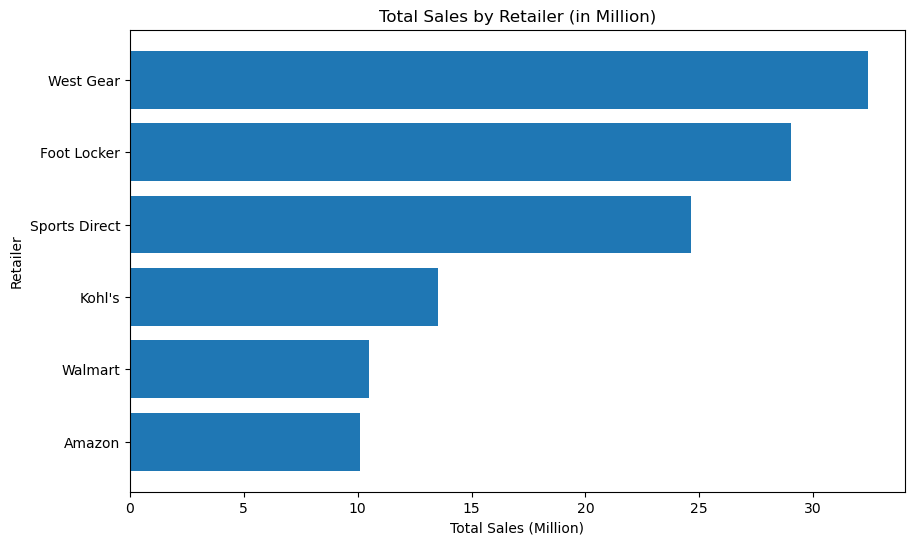

In [21]:
import matplotlib.pyplot as plt

sales_by_retailer = cleaned_df.groupby('retailer')['total_sales'].sum().reset_index()
sales_by_retailer.total_sales = sales_by_retailer.total_sales / 1000000 
sales_by_retailer = sales_by_retailer.sort_values(by='total_sales', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(sales_by_retailer['retailer'], sales_by_retailer['total_sales'])
plt.xlabel('Total Sales (Million)')
plt.ylabel('Retailer')
plt.title('Total Sales by Retailer (in Million)')
plt.gca().invert_yaxis()
plt.show()

### 2. Total Profit by Retailer

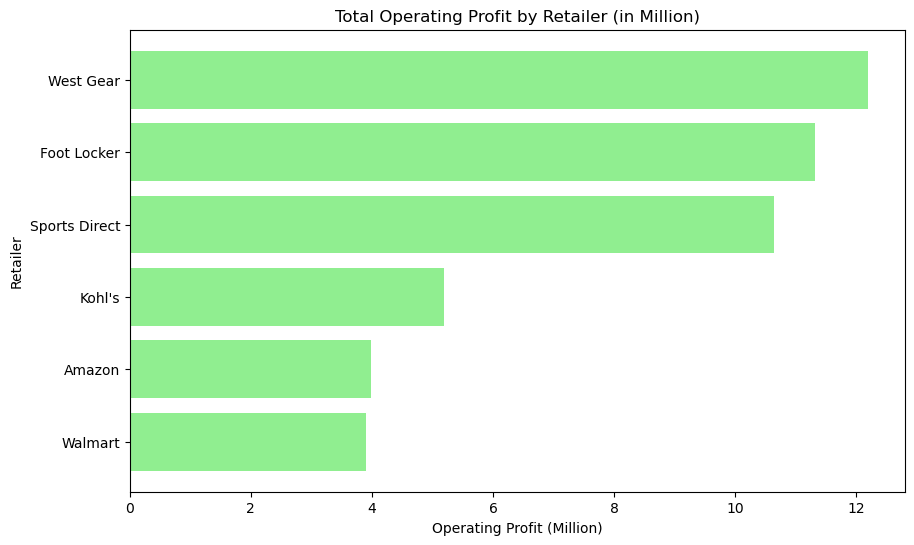

In [22]:
profit_by_retailer = cleaned_df.groupby('retailer')['operating_profit'].sum().reset_index()
profit_by_retailer.operating_profit = profit_by_retailer.operating_profit / 1000000  # Convert to million
profit_by_retailer = profit_by_retailer.sort_values(by='operating_profit', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(profit_by_retailer['retailer'], profit_by_retailer['operating_profit'], color='lightgreen')
plt.xlabel('Operating Profit (Million)')
plt.ylabel('Retailer')
plt.title('Total Operating Profit by Retailer (in Million)')
plt.gca().invert_yaxis()

plt.show()

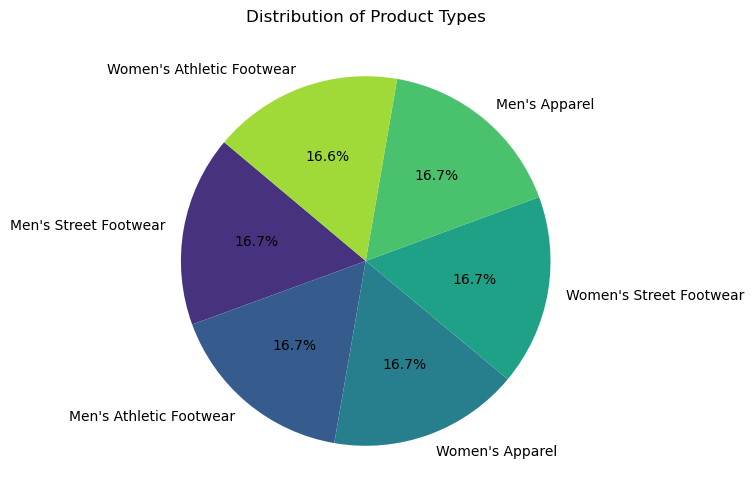

In [88]:
plt.figure(figsize=(6, 6))
product_type_counts = cleaned_df['product_type'].value_counts()
plt.pie(product_type_counts, labels=product_type_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))

plt.title('Distribution of Product Types')
plt.show()

# Mining Frequent Itemsets using Apriori Algorithm

### One-hot encoding to create transaction data

In [23]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# one-hot encoding to convert categorical variables into binary format
cleaned_df_encoded = pd.get_dummies(cleaned_df, columns=['product_type'], prefix='', prefix_sep='')
cleaned_df_encoded

,retailer,retailer_id,invoice_date,region,state,city,price_per_unit,units_sold,total_sales,operating_profit,operating_margin,sales_method,normalized_operating_profit,Men's Apparel,Men's Athletic Footwear,Men's Street Footwear,Women's Apparel,Women's Athletic Footwear,Women's Street Footwear
0,Foot Locker,1128299,2020-01-01,Northeast,Pennsylvania,Philadelphia,53.0,83,4399.0,1407.68,0.32,Outlet,0.034232,False,False,False,True,False,False
1,Foot Locker,1128299,2020-01-01,Northeast,Pennsylvania,Philadelphia,68.0,83,5644.0,2426.92,0.43,Online,0.060417,False,False,False,True,False,False
2,Foot Locker,1128299,2020-01-01,Northeast,New York,New York,34.0,384,13056.0,6789.12,0.52,Outlet,0.172484,False,False,True,False,False,False
3,Foot Locker,1128299,2020-01-01,Northeast,Pennsylvania,Philadelphia,75.0,275,20625.0,6187.50,0.30,Outlet,0.157028,False,False,False,True,False,False
4,Foot Locker,1128299,2020-01-01,Northeast,New York,New York,50.0,1200,60000.0,30000.00,0.50,In-store,0.768785,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9639,Foot Locker,1128299,2021-12-31,Northeast,Pennsylvania,Philadelphia,46.0,56,2576.0,1004.64,0.39,Outlet,0.023878,True,False,False,False,False,False
9640,Amazon,1185732,2021-12-31,Northeast,Maine,Portland,55.0,125,6875.0,1718.75,0.25,Outlet,0.042224,True,False,False,False,False,False
9641,Foot Locker,1128299,2021-12-31,Northeast,Pennsylvania,Philadelphia,63.0,47,2961.0,1362.06,0.46,Online,0.033060,True,False,False,False,False,False
9642,Amazon,1185732,2021-12-31,Northeast,Maine,Portland,52.0,36,1872.0,692.64,0.37,Online,0.015862,True,False,False,False,False,False


In [24]:
# creating encode_units function to encode units sold as binary values (1 if sold, 0 if not)
def encode_units(x):
    if x > 0:
        return 1
    else:
        return 0

In [25]:
basket_sets = cleaned_df_encoded.groupby(['retailer', 'invoice_date'])[['Men\'s Street Footwear', 'Men\'s Athletic Footwear', 'Men\'s Apparel', 'Women\'s Street Footwear', 'Women\'s Athletic Footwear', 'Women\'s Apparel']].sum()

basket_sets = basket_sets.applymap(encode_units)

basket_sets

Men's Street Footwear  Men's Athletic Footwear  \
retailer  invoice_date                                                   
Amazon    2021-01-13                        1                        1   
          2021-01-14                        1                        1   
          2021-01-21                        1                        1   
          2021-01-22                        1                        1   
          2021-01-24                        0                        0   
...                                       ...                      ...   
West Gear 2021-12-10                        1                        1   
          2021-12-16                        1                        1   
          2021-12-17                        0                        0   
          2021-12-19                        1                        1   
          2021-12-23                        1                        1   

                        Men's Apparel  Women's Street Footwear  \
retailer  invoice_date                                           
Amazon    2021-01-13                1                        1   
          2021-01-14                1                        1   
          2021-01-21                1                        1   
          2021-01-22                1                        1   
          2021-01-24                0                        0   
...                               ...                      ...   
West Gear 2021-12-10                1                        1   
          2021-12-16                1                        1   
          2021-12-17                1                        1   
          2021-12-19                1                        1   
          2021-12-23                1                        1   

                        Women's Athletic Footwear  Women's Apparel  
retailer  invoice_date                                              
Amazon    2021-01-13                            1                1  
          2021-01-14                            1                1  
          2021-01-21                            1                1  
          2021-01-22                            1                1  
          2021-01-24                            0                1  
...                                           ...              ...  
West Gear 2021-12-10                            1                1  
          2021-12-16                            1                1  
          2021-12-17                            1                1  
          2021-12-19                            1                1  
          2021-12-23                            1                1  

[1367 rows x 6 columns]

### Apriori Algorithm

In [26]:
# Applying Apriori algorithm with min_support = 0.5 to find frequent item sets
frequent_itemsets = apriori(basket_sets, min_support=0.5, use_colnames=True)
frequent_itemsets

/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets


#### When min_support is 0.5, there are no frequent itemsets.

In [27]:
# Applying Apriori algorithm with min_support = 0.4 to find frequent item sets
frequent_itemsets = apriori(basket_sets, min_support=0.4, use_colnames=True)
frequent_itemsets

/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.425018,(Men's Street Footwear)
1,0.428676,(Men's Athletic Footwear)
2,0.426481,(Men's Apparel)
3,0.429407,(Women's Street Footwear)
4,0.422824,(Women's Athletic Footwear)
5,0.423555,(Women's Apparel)


#### When min_support is 0.4, only frequent one itemsets are getting generated.

In [28]:
# Applying Apriori algorithm with min_support = 0.3 to find frequent item sets
frequent_itemsets = apriori(basket_sets, min_support=0.3, use_colnames=True)
frequent_itemsets

/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.425018,(Men's Street Footwear)
1,0.428676,(Men's Athletic Footwear)
2,0.426481,(Men's Apparel)
3,0.429407,(Women's Street Footwear)
4,0.422824,(Women's Athletic Footwear)
5,0.423555,(Women's Apparel)
6,0.300658,"(Men's Street Footwear, Men's Athletic Footwear)"
7,0.305779,"(Men's Street Footwear, Women's Street Footwear)"
8,0.301390,"(Men's Athletic Footwear, Women's Athletic Foo..."
9,0.303584,"(Men's Apparel, Women's Street Footwear)"


In [65]:
# Generating association rules using min. confidence value as 0.7
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Men's Street Footwear),(Men's Athletic Footwear),0.425018,0.428676,0.300658,0.707401,1.650200,0.118463,1.952584,0.685262
1,(Men's Athletic Footwear),(Men's Street Footwear),0.428676,0.425018,0.300658,0.701365,1.650200,0.118463,1.925367,0.689649
2,(Men's Street Footwear),(Women's Street Footwear),0.425018,0.429407,0.305779,0.719449,1.675446,0.123273,2.033830,0.701143
3,(Women's Street Footwear),(Men's Street Footwear),0.429407,0.425018,0.305779,0.712095,1.675446,0.123273,1.997126,0.706536
4,(Men's Athletic Footwear),(Women's Athletic Footwear),0.428676,0.422824,0.301390,0.703072,1.662801,0.120136,1.943824,0.697687
5,(Women's Athletic Footwear),(Men's Athletic Footwear),0.422824,0.428676,0.301390,0.712803,1.662801,0.120136,1.989309,0.690612
6,(Men's Apparel),(Women's Street Footwear),0.426481,0.429407,0.303584,0.711835,1.657715,0.120450,1.980092,0.691800
7,(Women's Street Footwear),(Men's Apparel),0.429407,0.426481,0.303584,0.706985,1.657715,0.120450,1.957299,0.695348


In [30]:
rules['antecedents'] = rules['antecedents'].apply(list)
rules['consequents'] = rules['consequents'].apply(list)

In [31]:
rules.to_excel('association_rules.xlsx', index=False)

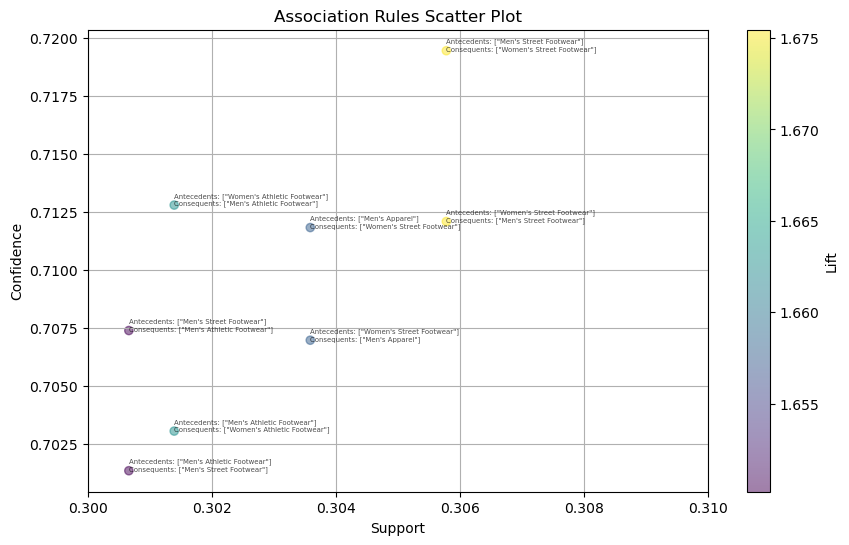

In [32]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], cmap='viridis', alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.colorbar(label='Lift')
plt.title('Association Rules Scatter Plot')
plt.xlim(0.3, 0.31)
plt.grid(True)

for i, row in rules.iterrows():
    plt.annotate(f"Antecedents: {list(row['antecedents'])}\nConsequents: {list(row['consequents'])}",
                 (row['support'], row['confidence']), fontsize=5, alpha=0.7)

plt.show()


## TIME SERIES ANALYSIS

# 1. ARIMA

In [33]:
cleaned_df.set_index('invoice_date', inplace=True)
cleaned_df.head()

,retailer,retailer_id,region,state,city,product_type,price_per_unit,units_sold,total_sales,operating_profit,operating_margin,sales_method,normalized_operating_profit
invoice_date,,,,,,,,,,,,,
2020-01-01,Foot Locker,1128299,Northeast,Pennsylvania,Philadelphia,Women's Apparel,53.0,83,4399.0,1407.68,0.32,Outlet,0.034232
2020-01-01,Foot Locker,1128299,Northeast,Pennsylvania,Philadelphia,Women's Apparel,68.0,83,5644.0,2426.92,0.43,Online,0.060417
2020-01-01,Foot Locker,1128299,Northeast,New York,New York,Men's Street Footwear,34.0,384,13056.0,6789.12,0.52,Outlet,0.172484
2020-01-01,Foot Locker,1128299,Northeast,Pennsylvania,Philadelphia,Women's Apparel,75.0,275,20625.0,6187.50,0.30,Outlet,0.157028
2020-01-01,Foot Locker,1128299,Northeast,New York,New York,Men's Street Footwear,50.0,1200,60000.0,30000.00,0.50,In-store,0.768785


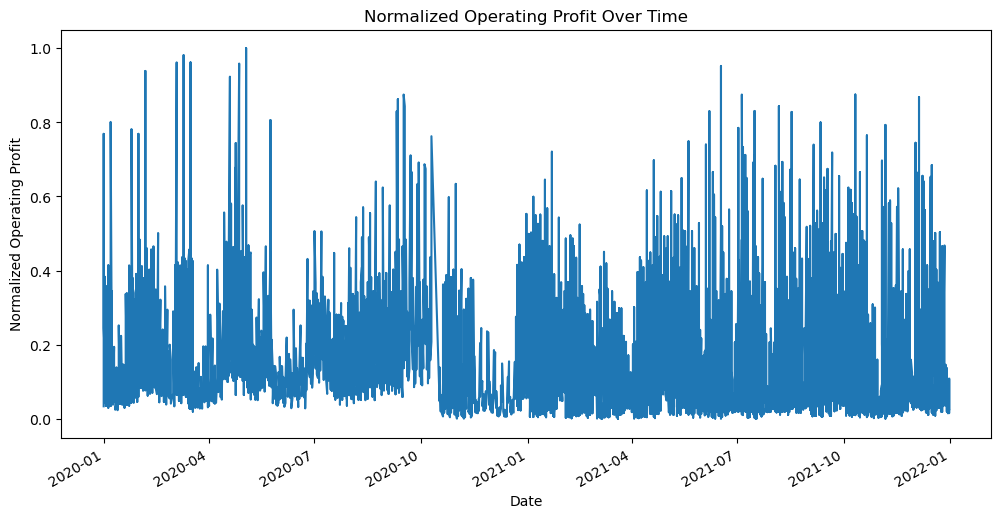

In [34]:
cleaned_df['normalized_operating_profit'].plot(figsize=(12, 6))
plt.title('Normalized Operating Profit Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Operating Profit')
plt.show()

In [35]:
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
    if result[1] <= 0.05:
        print("Reject the null hypothesis. The data is stationary.")
    else:
        print("Fail to reject the null hypothesis. The data is non-stationary.")

In [36]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    result = kpss(timeseries, regression='c', nlags='auto')
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[3])
    
    if result[1] <= 0.05:
        print("Reject the null hypothesis. The data is non-stationary.")
    else:
        print("Fail to reject the null hypothesis. The data is stationary.")

In [37]:
adf_test(cleaned_df['normalized_operating_profit'])

ADF Statistic: -13.525139040798713
p-value: 2.68762552107477e-25
Critical Values: {'1%': -3.4310298010186777, '5%': -2.8618404303123817, '10%': -2.566929913940464}
Reject the null hypothesis. The data is stationary.


In [38]:
kpss_test(cleaned_df['normalized_operating_profit'])

KPSS Statistic: 0.9399802996164609
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject the null hypothesis. The data is non-stationary.


/var/folders/gk/64vmdqys05vfzj3ywcq327z00000gn/T/ipykernel_24719/719958987.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(timeseries, regression='c', nlags='auto')


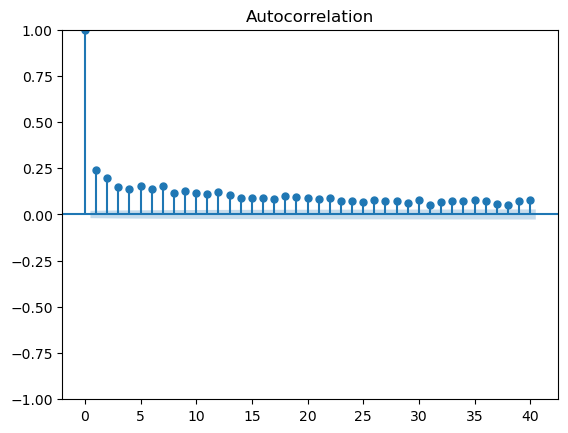

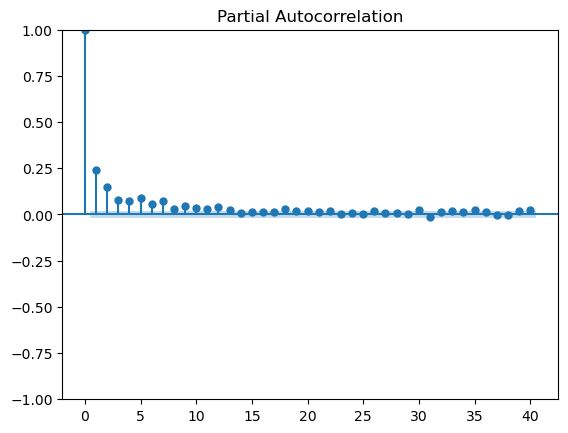

In [39]:
plot_acf(cleaned_df['operating_profit'])
plot_pacf(cleaned_df['operating_profit'])
plt.show()

In [40]:
diff1_df = cleaned_df.groupby('invoice_date').agg({'normalized_operating_profit': 'mean'}).reset_index()
diff1_df.head()

,invoice_date,normalized_operating_profit
0,2020-01-01,0.239749
1,2020-01-02,0.144706
2,2020-01-03,0.129587
3,2020-01-04,0.147279
4,2020-01-05,0.143933


In [41]:
diff1_df.set_index('invoice_date', inplace=True)
diff1_df['profit_diff'] = diff1_df['normalized_operating_profit'].diff()
diff1_df.dropna(inplace=True)
diff1_df.head()

,normalized_operating_profit,profit_diff
invoice_date,,
2020-01-02,0.144706,-0.095043
2020-01-03,0.129587,-0.015120
2020-01-04,0.147279,0.017692
2020-01-05,0.143933,-0.003346
2020-01-06,0.133537,-0.010396


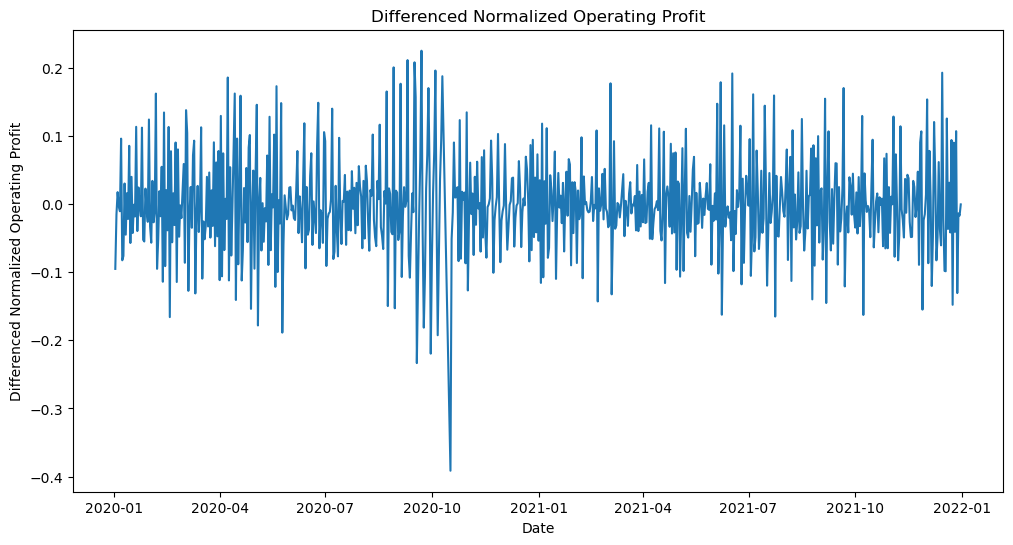

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(diff1_df['profit_diff'])
plt.title('Differenced Normalized Operating Profit')
plt.xlabel('Date')
plt.ylabel('Differenced Normalized Operating Profit')
plt.show()

In [43]:
adf_test(diff1_df.profit_diff)

ADF Statistic: -10.804877724668794
p-value: 1.974929402327461e-19
Critical Values: {'1%': -3.43955476721974, '5%': -2.865602155751202, '10%': -2.5689331692727135}
Reject the null hypothesis. The data is stationary.


In [44]:
kpss_test(diff1_df.profit_diff)

KPSS Statistic: 0.06042058173715764
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Fail to reject the null hypothesis. The data is stationary.


/var/folders/gk/64vmdqys05vfzj3ywcq327z00000gn/T/ipykernel_24719/719958987.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(timeseries, regression='c', nlags='auto')


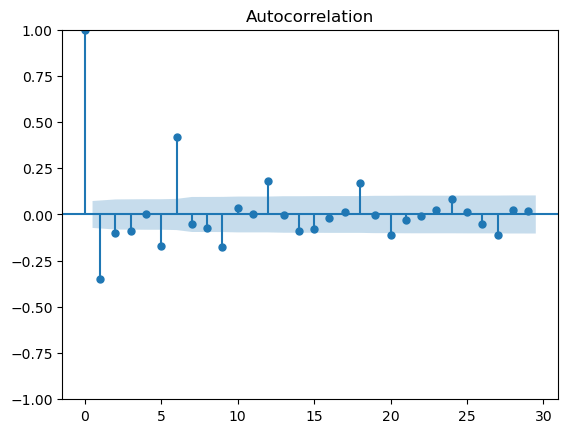

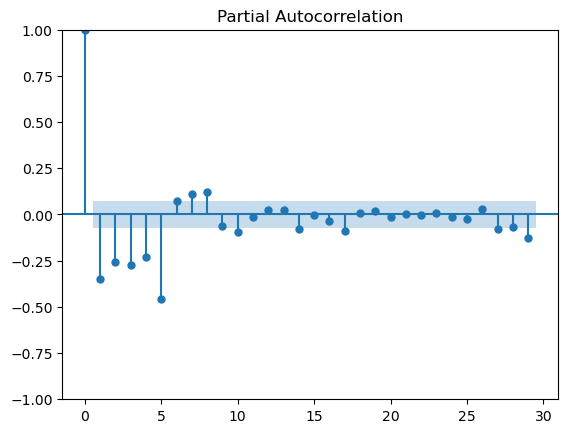

In [45]:
plot_acf(diff1_df.profit_diff)
plot_pacf(diff1_df.profit_diff)
plt.show()

#### from pacf, p = 6 and from acf q = 6 and d = 1

In [46]:
train_size = int(len(cleaned_df) * 0.8)
train, test = cleaned_df[:train_size], cleaned_df[train_size:]

In [47]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

p = d = q = range(0, 7)

pdq_combinations = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None
9
for pdq in pdq_combinations:
    try:
        model = ARIMA(cleaned_df['normalized_operating_profit'], order=pdq)
        results = model.fit()
        aic = results.aic

        if aic < best_aic:
            best_aic = aic
            best_pdq = pdq

    except Exception as e:
        continue

print("Best PDQ:", best_pdq)
print(best_aic)

Best PDQ: (2, 1, 5)
-13906.219125588985


In [85]:
print("Best PDQ:", best_pdq)
print("best AIC:", best_aic)

Best PDQ: (2, 1, 5)
best AIC: -13906.219125588985


In [48]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")
window_size = 100
model = None
predictions = []
true_values = []

for i in range(len(cleaned_df) - window_size):
    train_window = cleaned_df.iloc[i : i + window_size]
    test_window = cleaned_df.iloc[i + window_size : i + window_size + 1]

    model = ARIMA(train_window['normalized_operating_profit'], order=(2, 1, 5))
    ARIMA_model = model.fit()
    forecast = ARIMA_model.forecast(steps=1)
    predicted_value = forecast.values[0]
    predictions.append(predicted_value)
    true_values.append(test_window['normalized_operating_profit'].values[0])

In [49]:
mse = mean_squared_error(true_values, predictions)
print("Mean Squared Error (MSE):", mse)
mae = mean_absolute_error(true_values, predictions)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.01564506884497299
Mean Absolute Error (MAE): 0.08731099212796342


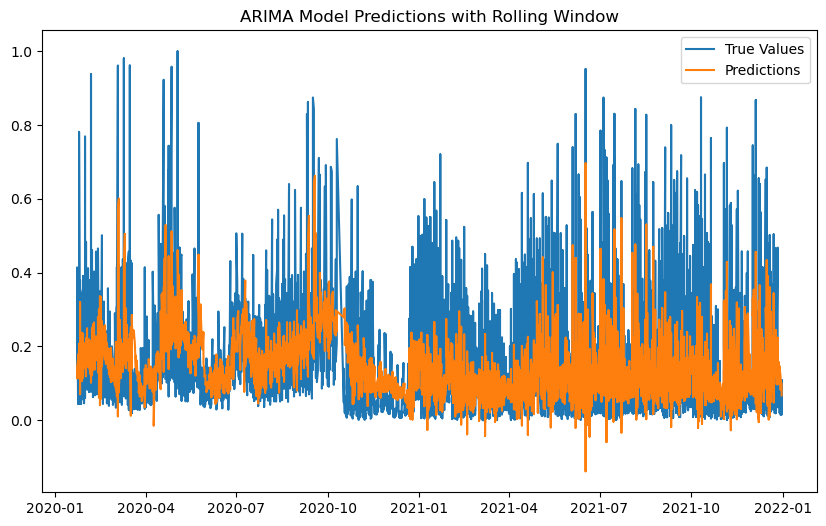

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(cleaned_df.index[window_size:], true_values, label="True Values")
plt.plot(cleaned_df.index[window_size:], predictions, label="Predictions")
plt.legend()
plt.title("ARIMA Model Predictions with Rolling Window")
plt.show()

# Regression

In [51]:
df_encoded = pd.get_dummies(df, columns=['retailer','region', 'state', 'city', 'product_type','sales_method'])
df_encoded

,retailer_id,invoice_date,price_per_unit,units_sold,total_sales,operating_profit,operating_margin,normalized_operating_profit,retailer_Amazon,retailer_Foot Locker,...,city_Wilmington,product_type_Men's Apparel,product_type_Men's Athletic Footwear,product_type_Men's Street Footwear,product_type_Women's Apparel,product_type_Women's Athletic Footwear,product_type_Women's Street Footwear,sales_method_In-store,sales_method_Online,sales_method_Outlet
0,1128299,2020-01-01,53.0,83,4399.0,1407.68,0.32,0.034232,False,True,...,False,False,False,False,True,False,False,False,False,True
1,1128299,2020-01-01,68.0,83,5644.0,2426.92,0.43,0.060417,False,True,...,False,False,False,False,True,False,False,False,True,False
2,1128299,2020-01-01,34.0,384,13056.0,6789.12,0.52,0.172484,False,True,...,False,False,False,True,False,False,False,False,False,True
3,1128299,2020-01-01,75.0,275,20625.0,6187.50,0.30,0.157028,False,True,...,False,False,False,False,True,False,False,False,False,True
4,1128299,2020-01-01,50.0,1200,60000.0,30000.00,0.50,0.768785,False,True,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9639,1128299,2021-12-31,46.0,56,2576.0,1004.64,0.39,0.023878,False,True,...,False,True,False,False,False,False,False,False,False,True
9640,1185732,2021-12-31,55.0,125,6875.0,1718.75,0.25,0.042224,True,False,...,False,True,False,False,False,False,False,False,False,True
9641,1128299,2021-12-31,63.0,47,2961.0,1362.06,0.46,0.033060,False,True,...,False,True,False,False,False,False,False,False,True,False
9642,1185732,2021-12-31,52.0,36,1872.0,692.64,0.37,0.015862,True,False,...,False,True,False,False,False,False,False,False,True,False


In [52]:
df_encoded['invoice_month'] = df['invoice_date'].dt.month
df_encoded['invoice_day'] = df['invoice_date'].dt.day
df_encoded['invoice_dayofweek'] = df['invoice_date'].dt.dayofweek
df_encoded = df_encoded.drop('invoice_date', axis=1)
df_encoded = df_encoded.drop('operating_profit', axis=1)
df_encoded.head()

,retailer_id,price_per_unit,units_sold,total_sales,operating_margin,normalized_operating_profit,retailer_Amazon,retailer_Foot Locker,retailer_Kohl's,retailer_Sports Direct,...,product_type_Men's Street Footwear,product_type_Women's Apparel,product_type_Women's Athletic Footwear,product_type_Women's Street Footwear,sales_method_In-store,sales_method_Online,sales_method_Outlet,invoice_month,invoice_day,invoice_dayofweek
0,1128299,53.0,83,4399.0,0.32,0.034232,False,True,False,False,...,False,True,False,False,False,False,True,1,1,2
1,1128299,68.0,83,5644.0,0.43,0.060417,False,True,False,False,...,False,True,False,False,False,True,False,1,1,2
2,1128299,34.0,384,13056.0,0.52,0.172484,False,True,False,False,...,True,False,False,False,False,False,True,1,1,2
3,1128299,75.0,275,20625.0,0.30,0.157028,False,True,False,False,...,False,True,False,False,False,False,True,1,1,2
4,1128299,50.0,1200,60000.0,0.50,0.768785,False,True,False,False,...,True,False,False,False,True,False,False,1,1,2


In [53]:
X = df_encoded.drop('normalized_operating_profit', axis=1)
X.head()

,retailer_id,price_per_unit,units_sold,total_sales,operating_margin,retailer_Amazon,retailer_Foot Locker,retailer_Kohl's,retailer_Sports Direct,retailer_Walmart,...,product_type_Men's Street Footwear,product_type_Women's Apparel,product_type_Women's Athletic Footwear,product_type_Women's Street Footwear,sales_method_In-store,sales_method_Online,sales_method_Outlet,invoice_month,invoice_day,invoice_dayofweek
0,1128299,53.0,83,4399.0,0.32,False,True,False,False,False,...,False,True,False,False,False,False,True,1,1,2
1,1128299,68.0,83,5644.0,0.43,False,True,False,False,False,...,False,True,False,False,False,True,False,1,1,2
2,1128299,34.0,384,13056.0,0.52,False,True,False,False,False,...,True,False,False,False,False,False,True,1,1,2
3,1128299,75.0,275,20625.0,0.30,False,True,False,False,False,...,False,True,False,False,False,False,True,1,1,2
4,1128299,50.0,1200,60000.0,0.50,False,True,False,False,False,...,True,False,False,False,True,False,False,1,1,2


In [54]:
Y = df_encoded.normalized_operating_profit
Y.head()

0    0.034232
1    0.060417
2    0.172484
3    0.157028
4    0.768785
Name: normalized_operating_profit, dtype: float64

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

In [56]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Linear Regression model
lr_clf = LinearRegression()

# Cross-validation predictions
Y_pred_cv = cross_val_predict(lr_clf, X_train, Y_train, cv=5)

# Model evaluation
lr_mse = mean_squared_error(Y_train, Y_pred_cv)
lr_mae = mean_absolute_error(Y_train, Y_pred_cv)

print("Mean Squared Error:", lr_mse)
print(" Mean Absolute Error:", lr_mae)

# Fit the model on the entire training set
lr_clf.fit(X_train, Y_train)
# Predictions on test set
Y_pred_test = lr_clf.predict(X_test)

Mean Squared Error: 0.0009069507103827049
 Mean Absolute Error: 0.01814793864608566


In [57]:
lr_best_score = lr_clf.score(X_test,Y_test)
lr_best_score

0.94665280402216

In [58]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

def evaluate_model(model, X, Y):
    y_pred = model.predict(X)
    mse = mean_squared_error(Y, y_pred)
    mae = mean_absolute_error(Y, y_pred)
    return mse, mae

def grid_search_for_model(model, param_grid, X, Y, cv):
    gs = GridSearchCV(model, param_grid, cv=cv, return_train_score=False)
    gs.fit(X, Y)
    best_model = gs.best_estimator_
    best_params = gs.best_params_
    mse, mae = evaluate_model(best_model, X, Y)
    return best_model, best_params, gs.best_score_, mse, mae

def find_best_model_using_gridsearchcv(X, Y):
    algos = {
        'lasso': {
            'model': Lasso(),
            'param_grid': {'alpha': [1, 2], 'selection': ['random', 'cyclic']}
        },
        'ridge': {
            'model': Ridge(),
            'param_grid': {'alpha': [1, 2], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'param_grid': {'criterion': ['squared_error', 'friedman_mse'], 'splitter': ['best', 'random']}
        },
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
    

    for algo_name, config in algos.items():
        best_model, best_params, best_score, mse, mae = grid_search_for_model(config['model'], config['param_grid'], X, Y, cv)
        
        scores.append({
            'model': algo_name,
            'best_score': best_score,
            'best_params': best_params,
            'best_mse': mse,
            'best_mae': mae
        })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params', 'best_mse', 'best_mae'])

In [59]:
results_df = find_best_model_using_gridsearchcv(X, Y)
results_df

/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yeshwanth/anaconda3/lib/python3.11/sit

,model,best_score,best_params,best_mse,best_mae
0,lasso,0.882134,"{'alpha': 2, 'selection': 'cyclic'}",1.937254e-03,2.449554e-02
1,ridge,0.946749,"{'alpha': 1, 'solver': 'auto'}",8.746863e-04,1.776262e-02
2,decision_tree,0.997306,"{'criterion': 'friedman_mse', 'splitter': 'best'}",3.219718e-34,6.101571e-18


In [60]:
results_df.loc[len(results_df)] = ['ARIMA', best_aic, best_pdq, mse, mae]

# Assuming you already have the DataFrame df_models with the results for lasso, ridge, decision_tree, random_forest, and arima
results_df.loc[len(results_df)] = ['linear_regression', lr_best_score, None, lr_mse, lr_mae]

In [61]:
results_df

,model,best_score,best_params,best_mse,best_mae
0,lasso,0.882134,"{'alpha': 2, 'selection': 'cyclic'}",1.937254e-03,2.449554e-02
1,ridge,0.946749,"{'alpha': 1, 'solver': 'auto'}",8.746863e-04,1.776262e-02
2,decision_tree,0.997306,"{'criterion': 'friedman_mse', 'splitter': 'best'}",3.219718e-34,6.101571e-18
3,ARIMA,-13906.219126,"(2, 1, 5)",1.564507e-02,8.731099e-02
4,linear_regression,0.946653,None,9.069507e-04,1.814794e-02


In [62]:
results_df[results_df.best_mse == results_df.best_mse.min()]

,model,best_score,best_params,best_mse,best_mae
2,decision_tree,0.997306,"{'criterion': 'friedman_mse', 'splitter': 'best'}",3.219718e-34,6.101571e-18


In [63]:
results_df[results_df.best_mse == results_df.best_mse.max()]

,model,best_score,best_params,best_mse,best_mae
3,ARIMA,-13906.219126,"(2, 1, 5)",0.015645,0.087311


In [64]:
results_mse = results_df[['model', 'best_params', 'best_mse']].sort_values('best_mse').reset_index(drop=True)
results_mse

,model,best_params,best_mse
0,decision_tree,"{'criterion': 'friedman_mse', 'splitter': 'best'}",3.219718e-34
1,ridge,"{'alpha': 1, 'solver': 'auto'}",8.746863e-04
2,linear_regression,None,9.069507e-04
3,lasso,"{'alpha': 2, 'selection': 'cyclic'}",1.937254e-03
4,ARIMA,"(2, 1, 5)",1.564507e-02


In [68]:
regression_results = results_df.sort_values('best_score', ascending= False).reset_index(drop=True)[:4]
regression_results

,model,best_score,best_params,best_mse,best_mae
0,decision_tree,0.997306,"{'criterion': 'friedman_mse', 'splitter': 'best'}",3.219718e-34,6.101571e-18
1,ridge,0.946749,"{'alpha': 1, 'solver': 'auto'}",8.746863e-04,1.776262e-02
2,linear_regression,0.946653,None,9.069507e-04,1.814794e-02
3,lasso,0.882134,"{'alpha': 2, 'selection': 'cyclic'}",1.937254e-03,2.449554e-02


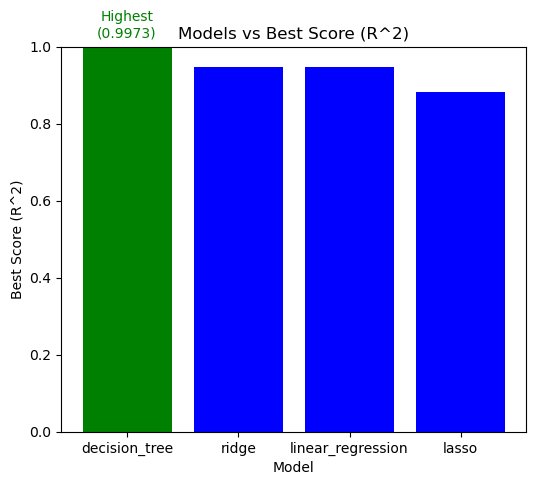

In [83]:
models = ["decision_tree", "ridge", "linear_regression", "lasso"]
best_scores = [0.997306, 0.946749, 0.946653, 0.882134]

# Find the index of the model with the highest best score
best_score_index = best_scores.index(max(best_scores))

# Plotting the graph
plt.figure(figsize=(6, 5))
plt.bar(models, best_scores, color=['blue' if i != best_score_index else 'green' for i in range(len(models))])
plt.xlabel('Model')
plt.ylabel('Best Score (R^2)')
plt.title('Models vs Best Score (R^2)')
plt.ylim(0, 1)  # Adjust the y-axis limits if necessary

# Highlight the highest best score
plt.text(best_score_index, max(best_scores) + 0.02, f'Highest\n({max(best_scores):.4f})', ha='center', va='bottom', color='green')

# Show the plot
plt.show()